In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import *
from sklearn.preprocessing import *
from sklearn.metrics import *
from imblearn.under_sampling import RandomUnderSampler
from sklearn.decomposition import PCA
from sklearn.base import TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

import lightgbm as lgb
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# libs for feature selection
from sklearn.inspection import permutation_importance
import phik

# lib for tuning
import optuna
from optuna import Trial

from IPython.display import display
import logging
import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/soq-hack-datasets/sample_submission.csv
/kaggle/input/soq-hack-datasets/train.csv
/kaggle/input/soq-hack-datasets/test.csv
/kaggle/input/soq-hack-datasets/solution.csv


# Short Notebook Describtion

This notebook is dedicated to solve **binary classification problem**, where **one class is rare** (the bulk of trades (99%) fall into the "hold" category, while only 1% are short and long positions). To solve this problem I used **feature engineering** and three tuned (**with optuna**) boostings. In the end I tried to implement **ensembles**.<br>
* If you have what to add in this solution or you know, who to do it better - write about it in comments, please! <br>
* In the end of notebook you can see all authors! <br>
* **Please, upvote this notebook, if it's useful for you. It's important for me!**

In [ ]:
# for github
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')
solution = pd.read_csv('Data/solution.csv')

In [2]:
# datasets from school of quants hackathon
"""train = pd.read_csv('/kaggle/input/soq-hack-datasets/train.csv')
test = pd.read_csv('/kaggle/input/soq-hack-datasets/test.csv')
solution = pd.read_csv('/kaggle/input/soq-hack-datasets/solution.csv')"""

# Data Description


In [3]:
train.columns

Index(['rsi_sig', 'vwap_short', 'resist3', 'stoch_k', 'vwap_long', 'support3',
       'fibo_sig', 'result', 'stoch_k_sm', 'boll_up', 'stoch_d', 'ichi_sig',
       'boll_low', 'stoch_sig', 'macd_rel', 'pivot_pt', 'macd_sig_rel',
       'wma_rel', 'stoch_sig_val', 's&p500', 'ichi_a', 'boll_sig', 'adx',
       'ichi_conv', 'ma_rel', 'sma_rel', 'rsi', 'sar_rel', 'macd', 'support2',
       'atr', 'resist1', 'ema_rel', 'support1', 'ichi_base', 'exch', 'resist2',
       'ichi_b', 'macd_hist_rel'],
      dtype='object')

In [4]:
train.head(3)

,rsi_sig,vwap_short,resist3,stoch_k,vwap_long,support3,fibo_sig,result,stoch_k_sm,boll_up,...,support2,atr,resist1,ema_rel,support1,ichi_base,exch,resist2,ichi_b,macd_hist_rel
0,Hold,0.000314,32.11,5.115713,-0.000094,-24.93,Sell,0,41.644171,0.005576,...,-10.67,0.002527,9.50,1.026437,-4.76,2.722192,BC,17.85,5.110871,-1.027237
1,Sell,0.000000,5.60,85.714286,0.000002,-6.44,Buy,1,113.015873,0.017626,...,-3.43,0.000207,1.37,0.995089,-1.64,-1.103310,BB,2.59,-0.451354,-0.993209
2,Hold,0.000000,1.30,50.000000,0.000000,-1.30,Sell,1,46.666667,0.002156,...,-0.65,0.000005,0.28,1.000046,-0.37,-0.061000,BB,0.65,-0.020333,-0.999840


### Categorical Columns:

**`rsi_sig`**: Relative Strength Index (RSI) indicator, which helps identify whether an asset is overbought or oversold.

**`stoch_sig`**: Stochastic Oscillator, used for generating potential trading signals by identifying overbought and oversold conditions.

**`ichi_sig`**: Ichimoku indicator, which helps determine support and resistance levels, as well as market momentum.

**`fibo_sig`**: Fibonacci levels, used to identify potential support and resistance zones.

**`boll_sig`**: Bollinger Bands indicator, which helps assess market volatility and identify potential entry and exit points for trades.

**`exch`**: The exchange or trading platform where the transaction took place.

### Numerical Columns:

**`ichi_conv, ichi_base, ichi_a, ichi_b`**: Various components of the Ichimoku indicator, which help determine trends and potential reversal points.

**`support1, resist1, support2, resist2, support3, resist3`**: Support and resistance levels, which help traders and analysts identify potential price reversal zones and make more informed trading decisions.

**`macd, macd_rel, macd_sig_rel, macd_hist_rel`**: MACD indicator, which helps identify the direction and strength of a trend.

**`adx`**: Average Directional Index, which helps measure the strength of a trend.

**`atr`**: Average True Range, used to evaluate market volatility.

**`ma_rel, sma_rel, ema_rel, wma_rel`**: Moving averages (MA, SMA, EMA, WMA), which help identify the current market trend based on historical data.

**`s&p500`**: Movement of the S&P 500 index within a 15-minute window.

**`vwap_short, vwap_long`**: VWAP (volume-weighted average price) for short and long positions, used to identify optimal trading opportunities.

**`rsi, sar_rel`**: RSI indicator and Parabolic Stop and Reverse (SAR) indicator, which help track price movement dynamics.

**`stoch_k, stoch_d, stoch_k_sm, stoch_sig_val`**: Various aspects of the Stochastic Oscillator, which help analyze market dynamics.

**`boll_up, boll_low`**: Upper and lower Bollinger Bands, used to assess market volatility.

**`pivot_pt`**: Pivot point, which helps determine the overall market trend.

### Target:

**`result`**: Column representing the target variable in your dataset.
**Target values: 1 - "holding" strategy; 0 - long or short position.**

# Feature Engineering

Let's create **NEW FEATURES** based on technical analisys and maybe can help our model to predict right stratagy

* **`The ratio of resistance level to support level`** can indicate how clear the market is in its direction.
  * **Justification:** The closer this ratio is to 1, the more uncertain market participants are. In such cases, it might be better to stick to a "holding" strategy.
* **`Double overbought/oversold signal`**. If `RSI` and `stoch_k` are simultaneously in the overbought or oversold zones (feature value: 1), holding is unlikely.
* **`Volatility and trend strength`**. If market volatility (`ATR`) increases alongside the trend strength (`ADX`), it is likely not the best moment for holding.
* **`S&P500 as a market sentiment indicator`**. If this index shows sharp changes in its prices, it may indicate that financial market participants are ready to start selling/buying instead of holding.
* **`VWAP`**. If volume-weighted average prices change sharply, it signals activity among financial market participants.

In [5]:
def feature_generating(df):
    df = df.copy()
    
    # ratio of resistance level to support level
    df['support1_vs_resist1'] = df['support1'] / df['resist1']
    df['support2_vs_resist2'] = df['support2'] / df['resist2']
    df['support3_vs_resist3'] = df['support3'] / df['resist3']
    
    # double signal "is overbought or oversold"
    df['double_sig'] = ((df['rsi'] > 70) & (df['stoch_k'] > 80)) | \
                        ((df['rsi'] < 30) & (df['stoch_k'] < 20))
    df['double_sig'] = df['double_sig'].astype(int)
    
    # Volatility and Trend Strength
    df['atr&adx'] = df['atr'] * df['adx']
    
    # S&P500 - "Market Sentiment Indicator"
    df['sp500_pct_change'] = df['s&p500'].pct_change()
    df['sp500_movement'] = (df['sp500_pct_change'].abs() > 0.005).astype(int)
    
    # VWAP
    df['vwap_short_pct_change'] = df['vwap_short'].pct_change()
    df['vwap_long_pct_change'] = df['vwap_long'].pct_change()
    
    df['vwap_short_signal'] = (df['vwap_short_pct_change'].abs() > 0.005).astype(int)
    df['vwap_long_signal'] = (df['vwap_long_pct_change'].abs() > 0.005).astype(int)
    
    df = df.fillna(method='bfill')
    df = df.replace(-np.inf, np.nan)
    df = df.fillna(df.min())
    df = df.replace(np.inf, np.nan)
    df = df.fillna(df.max())
    
    return df

In [6]:
train = feature_generating(train)
test = feature_generating(test)
solution = feature_generating(solution)

In [7]:
train.shape, test.shape, solution.shape

((1366032, 50), (341166, 50), (342, 49))

In [8]:
train.head(3)

,rsi_sig,vwap_short,resist3,stoch_k,vwap_long,support3,fibo_sig,result,stoch_k_sm,boll_up,...,support2_vs_resist2,support3_vs_resist3,double_sig,atr&adx,sp500_pct_change,sp500_movement,vwap_short_pct_change,vwap_long_pct_change,vwap_short_signal,vwap_long_signal
0,Hold,0.000314,32.11,5.115713,-0.000094,-24.93,Sell,0,41.644171,0.005576,...,-0.597759,-0.776394,0,0.028428,-1.182713,0,-1.000000e+00,-1.016865,0,0
1,Sell,0.000000,5.60,85.714286,0.000002,-6.44,Buy,1,113.015873,0.017626,...,-1.324324,-1.150000,1,0.020667,-1.182713,1,-1.000000e+00,-1.016865,1,1
2,Hold,0.000000,1.30,50.000000,0.000000,-1.30,Sell,1,46.666667,0.002156,...,-1.000000,-1.000000,0,0.000199,-4.247369,1,-3.335380e+15,-1.000000,0,1


There are too much objects and features, so let's try to decrease these numbers with minimum loss of data-information. First, I tried to **fit and tune** CatBoost, using all data, but it was loading approximately 8 hours - that's not ok for this model.

In [9]:
def converter(df):
    '''
    Maybe pure attempt to help our model, but let it be!
    '''
    float_num_features = df.select_dtypes('float64').columns
    int_num_features = df.select_dtypes(['int64', 'int32']).columns
    df[float_num_features] = df[float_num_features].astype('float32')
    df[int_num_features] = df[int_num_features].astype('int16')
    
    return df

In [10]:
# THAT'S WRONG!
# We need to use another way of implementing PCA in this task
# because method instance have to be common for train and test datasets
# It's significant to fit_transform train dataset and then transform test.
# So, only Transformer can overcome this problem
def make_pca(df, pca):
    '''
    PCA helps to decrease number of features by saving the most important 
    information from the initial data and using Singular Value Decomposition 
    of the data to project it to a lower dimensional space. 
    The input data is centered but not scaled for each feature before applying the SVD!
    '''
    num_features = df.select_dtypes('float32').columns
    
    pca = PCA(n_components=0.98)
    df_new_num_features = pd.DataFrame(pca.fit_transform(df[num_features]))
    df = df.drop(num_features, axis=1)
    df = df.reset_index(drop=True)
    df_new_num_features = df_new_num_features.reset_index(drop=True)
    df = pd.concat([df_new_num_features, df], axis=1)
    
    return df

NameError("This code won't work right")

NameError("This code won't work right")

**[What is PCA?](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)**

In [11]:
class Transformer(TransformerMixin):
    '''
    This class is needed to provide right transformation of train&test datasets.
    PCA helps to compress dataset while preserving core information.
    
    This class can also include OHE or more appropriate encoder
    '''
    def __init__(self, n_components):
        super().__init__()

        self.PCA = PCA(n_components = n_components)
        self.scaler = StandardScaler()

    def fit(self, df):
        num_cols = df.select_dtypes('float32').columns
        scaled = self.scaler.fit_transform(df[num_cols])

        self.PCA.fit(scaled)

        return self

    def transform(self, df):
        num_cols = df.select_dtypes('float32').columns
        # cat_cols = df.select_dtypes('object').columns

        scaled = self.scaler.transform(df[num_cols])

        features = self.PCA.transform(scaled)
        # cat_features = self.encoder.transform(df[cat_cols])
        del scaled

        assert len(features) == len(df), 'Trouble'

        df = df.drop(num_cols, axis = 1)
        # df = df.drop(cat_cols, axis = 1)
        cols = [str(i) for i in np.arange(features.shape[1])]
        # cat_cols = self.encoder.get_feature_names_out(cat_cols)
        # cat_cols = [str(i) for i in np.arange(features.shape[1], features.shape[1] + cat_features.argmaxshape[1])]
        df = pd.concat([df, pd.DataFrame(features, index = df.index, columns=cols)], axis = 1)
        
        # in case of using encoder for categorical features
        # df = pd.concat([df, pd.DataFrame(features, index = df.index, columns=cols),
        #               pd.DataFrame(cat_features, index = df.index, columns = cat_cols)], 
        #               axis = 1)
                
        return df

In [12]:
train = converter(train)
test = converter(test)

solution = converter(solution)

The last method (in this solution) to decrease shape of initial dataframes: [UnderSampler](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html)

In [13]:
rus = RandomUnderSampler(sampling_strategy=0.6, random_state=42)
X_train, y_train = rus.fit_resample(train.drop(['result'], axis=1), train['result'])
train = pd.concat([X_train, y_train], axis=1)

In [14]:
train.shape

(397746, 50)

In [15]:
transformer = Transformer(n_components=0.98)
transformer.fit(train)
transformed_train = transformer.transform(train)

In [16]:
transformed_test = transformer.transform(test)

In [17]:
X_train = transformed_train.drop(['result'], axis=1)
y_train = transformed_train['result']

X_test = transformed_test.drop(['result'], axis=1)
y_test = transformed_test['result']

In [18]:
cat_features = ['rsi_sig', 'stoch_sig', 'ichi_sig', 'fibo_sig', 'boll_sig', 'exch', 'double_sig', 'sp500_movement', 'vwap_short_signal', 'vwap_long_signal']
#num_features = [i for i in train.columns if (i not in cat_features) & (i != 'result')]

target = 'result'

# Boostings

## CatBoost baseline

I use it to perform further **feature selection**

In [19]:
catboost = CatBoostClassifier(random_state=42, 
                              thread_count=-1, 
                              cat_features=cat_features,
                              eval_metric='F1',
                              verbose=200)
catboost.fit(X_train, 
             y_train, 
             eval_set=(X_test, y_test), 
             verbose=200, 
             use_best_model=True, 
             early_stopping_rounds=100)

prediction = catboost.predict(X_test)

Learning rate set to 0.138999
0:	learn: 0.8316357	test: 0.9038114	best: 0.9038114 (0)	total: 688ms	remaining: 11m 27s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9383241303
bestIteration = 22

Shrink model to first 23 iterations.


In [20]:
# f1-score was main score in SOQ hack
print(f'F1-score: {f1_score(y_test, prediction)}')

F1-score: 0.9383241302822176


## Tuned CatBoost

**Feature selection**

In [21]:
# Final amount of features may be less! 
n_features=15

In [22]:
# feature importance from CatBoost

feature_importance_df = catboost.get_feature_importance(prettified=True)
best_features_1 = feature_importance_df[:n_features]['Feature Id'].values.tolist()

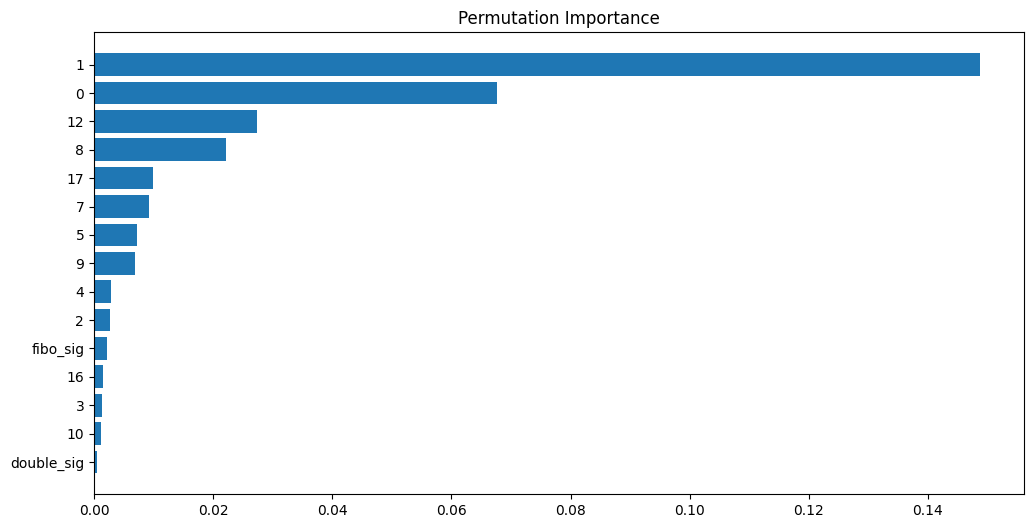

In [23]:
# permutation importance

perm_importance = permutation_importance(catboost, X_train, y_train, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()[-n_features:]
best_features_2 = X_train.columns[sorted_idx][-n_features:].values
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.title('Permutation Importance');

In [24]:
# let's see final list of best features:
best_features = [i for i in X_train.columns if (i in best_features_1) & (i in best_features_2)]
best_features

['fibo_sig',
 'double_sig',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '7',
 '8',
 '9',
 '10',
 '12',
 '16',
 '17']

In [25]:
best_cat_features = [i for i in cat_features if i in best_features]

### Tuning using optuna

In [26]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-5, 10),
        'bagging_temperature': trial.suggest_uniform('bagging_temperature', 0, 1),
        'random_strength': trial.suggest_uniform('random_strength', 0, 10),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'one_hot_max_size': trial.suggest_int('one_hot_max_size', 2, 100),
        'rsm': trial.suggest_uniform('rsm', 0.5, 1.0),
        'verbose': False,
        'eval_metric': 'F1'
    }
        
    catboost = CatBoostClassifier(**params, cat_features=best_cat_features)
    
    catboost.fit(X_train[best_features], y_train, verbose=False)
    prediction = catboost.predict(X_test[best_features])
    
    return f1_score(y_test, prediction)

In [27]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

df = study.trials_dataframe()

[I 2024-09-07 10:03:36,869] A new study created in memory with name: no-name-a718ad13-4392-464e-b83e-8dcc1a8186b1


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-09-07 10:03:45,371] Trial 0 finished with value: 0.9387442186546425 and parameters: {'iterations': 139, 'learning_rate': 0.028715182729287723, 'depth': 6, 'l2_leaf_reg': 0.0019286143297896716, 'bagging_temperature': 0.20856673649802382, 'random_strength': 9.640731776774176, 'border_count': 220, 'min_data_in_leaf': 33, 'one_hot_max_size': 76, 'rsm': 0.7646930438639662}. Best is trial 0 with value: 0.9387442186546425.
[I 2024-09-07 10:04:30,201] Trial 1 finished with value: 0.9230800246627767 and parameters: {'iterations': 785, 'learning_rate': 0.00013704818970128264, 'depth': 4, 'l2_leaf_reg': 1.1833761411086563e-05, 'bagging_temperature': 0.7487993904550556, 'random_strength': 8.478854683686114, 'border_count': 108, 'min_data_in_leaf': 56, 'one_hot_max_size': 4, 'rsm': 0.7389594401752454}. Best is trial 0 with value: 0.9387442186546425.
[I 2024-09-07 10:05:22,206] Trial 2 finished with value: 0.9330827294990275 and parameters: {'iterations': 596, 'learning_rate': 6.877800782591

Training has stopped (degenerate solution on iteration 845, probably too small l2-regularization, try to increase it)


[I 2024-09-07 10:13:46,898] Trial 15 finished with value: 0.9344898347466841 and parameters: {'iterations': 990, 'learning_rate': 0.020045978204489848, 'depth': 5, 'l2_leaf_reg': 0.00016375808766732185, 'bagging_temperature': 0.5900971450984012, 'random_strength': 8.155702284749996, 'border_count': 203, 'min_data_in_leaf': 38, 'one_hot_max_size': 74, 'rsm': 0.9136266117234015}. Best is trial 8 with value: 0.9392114536259952.
[I 2024-09-07 10:14:48,883] Trial 16 finished with value: 0.9396905737257857 and parameters: {'iterations': 676, 'learning_rate': 0.00279830568140028, 'depth': 8, 'l2_leaf_reg': 0.0013547542770492524, 'bagging_temperature': 0.9981492107858306, 'random_strength': 9.731743461734327, 'border_count': 129, 'min_data_in_leaf': 55, 'one_hot_max_size': 22, 'rsm': 0.5798939832879897}. Best is trial 16 with value: 0.9396905737257857.
[I 2024-09-07 10:15:53,875] Trial 17 finished with value: 0.9392399406628889 and parameters: {'iterations': 712, 'learning_rate': 0.00277542327

In [28]:
study.best_params

{'iterations': 560,
 'learning_rate': 0.00570046202966834,
 'depth': 6,
 'l2_leaf_reg': 0.006361605390701905,
 'bagging_temperature': 0.43471964630532567,
 'random_strength': 9.583068267306428,
 'border_count': 66,
 'min_data_in_leaf': 65,
 'one_hot_max_size': 6,
 'rsm': 0.7413645986823539}

In [29]:
# here it's important to change opt dict due to other best params. maybe now 
# (n_trails = 50)
params = {'iterations': 560,
 'learning_rate': 0.00570046202966834,
 'depth': 6,
 'l2_leaf_reg': 0.006361605390701905,
 'bagging_temperature': 0.43471964630532567,
 'random_strength': 9.583068267306428,
 'border_count': 66,
 'min_data_in_leaf': 65,
 'one_hot_max_size': 6,
 'rsm': 0.7413645986823539}

cat_model = CatBoostClassifier(**params, cat_features=cat_features)
cat_model.fit(X_train, y_train, verbose=False)

In [30]:
cat_prediction = cat_model.predict_proba(X_test)

In [31]:
# probability of class "1"
cat_prediction = cat_prediction[:, 1]
cat_prediction

array([0.88749352, 0.69047893, 0.84441446, ..., 0.36583244, 0.84177741,
       0.81440451])

That was learning & prediction in validation dataset. Now let's predict based on new data without target. I do the same

In [32]:
df_final = pd.concat([train, test], axis = 0, ignore_index = True)

In [33]:
X = df_final.drop(['result'], axis=1)
y = df_final['result']

In [34]:
# n_trails = 50
params = {'iterations': 560,
 'learning_rate': 0.00570046202966834,
 'depth': 6,
 'l2_leaf_reg': 0.006361605390701905,
 'bagging_temperature': 0.43471964630532567,
 'random_strength': 9.583068267306428,
 'border_count': 66,
 'min_data_in_leaf': 65,
 'one_hot_max_size': 6,
 'rsm': 0.7413645986823539}

final_cat_model = CatBoostClassifier(**params, cat_features=cat_features)
final_cat_model.fit(X, y, verbose=False)

In [35]:
final_cat_prediction = final_cat_model.predict_proba(solution)

In [36]:
# probability of class "1"
final_cat_prediction = final_cat_prediction[:, 1]
final_cat_prediction

array([0.94465414, 0.64385435, 0.80896708, 0.98261217, 0.31435689,
       0.07134033, 0.98112286, 0.90909133, 0.98699516, 0.61309309,
       0.95483693, 0.69020601, 0.09410736, 0.95585356, 0.08863325,
       0.96521946, 0.56590492, 0.91267315, 0.96768892, 0.9754919 ,
       0.74637016, 0.98715392, 0.89800889, 0.52533293, 0.87164742,
       0.93779624, 0.12192725, 0.96865658, 0.80472889, 0.10800302,
       0.98656553, 0.9815768 , 0.92282756, 0.99357182, 0.93604307,
       0.80141694, 0.98509996, 0.96299796, 0.94771112, 0.94409198,
       0.44390327, 0.90547866, 0.9829833 , 0.67898511, 0.86461129,
       0.95876179, 0.13911524, 0.97725869, 0.88213057, 0.55127023,
       0.75346334, 0.92971794, 0.97044691, 0.91545807, 0.98362629,
       0.46932972, 0.98430134, 0.96108371, 0.71045528, 0.9819628 ,
       0.97953077, 0.93687254, 0.9616954 , 0.97511471, 0.74437401,
       0.99060216, 0.98056847, 0.95274844, 0.97460778, 0.94141451,
       0.94302305, 0.97746353, 0.98814922, 0.86558792, 0.25000

In [37]:
submission = pd.DataFrame({'ID':solution.index})
submission['result'] = final_cat_model.predict(solution)

In [38]:
# saving results
# submission.to_csv('Tuned_CatBoost.csv',index=False)

In [39]:
submission['result'].value_counts()

result
1    302
0     40
Name: count, dtype: int64

## XGBoost baseline for feature importance

**Implementation of XGBoost and LightBoost is about the same.** The only diffearence that we need to encode categorical features before we use it during fitting and predicting.

In [40]:
encoder = LabelEncoder()

In [41]:
for col in cat_features:
    X_train[col] = encoder.fit_transform(X_train[col])
    X_test[col] = encoder.transform(X_test[col])
    
for col in cat_features:
    X_train[col] = X_train[col].astype('int')
    X_test[col] = X_test[col].astype('int')

In [42]:
xgb_model = XGBClassifier(objective='binary:logistic', tree_method='hist', enable_categorical=True)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [43]:
xgb_prediction = xgb_model.predict(X_test)

In [44]:
print(f'F1-score: {f1_score(y_test, xgb_prediction)}')

F1-score: 0.9165461003378174


## Tuned XGBoost

In [45]:
feature_important = xgb_model.get_booster().get_score(importance_type='weight')

In [46]:
feature_important
sorted_feature_important = sorted(feature_important.items(), key=lambda item: item[1])

In [47]:
sorted_feature_important[-n_features:]

[('13', 207.0),
 ('3', 242.0),
 ('15', 256.0),
 ('5', 259.0),
 ('11', 267.0),
 ('17', 278.0),
 ('7', 283.0),
 ('18', 286.0),
 ('2', 303.0),
 ('4', 335.0),
 ('9', 396.0),
 ('8', 457.0),
 ('1', 472.0),
 ('0', 474.0),
 ('12', 487.0)]

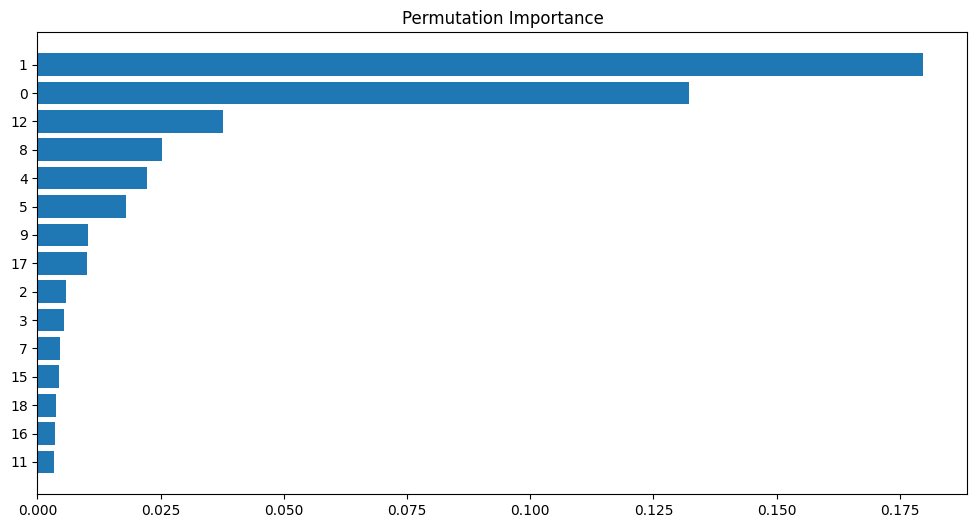

In [48]:
perm_importance = permutation_importance(xgb_model, X_train, y_train, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()[-n_features:]
best_features_2 = X_train.columns[sorted_idx][-n_features:].values
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.title('Permutation Importance');

In [49]:
best_features_1 = ['14', '3', '13', '5', '18', '17', '2', '8', '10', '4', '11', '9', '0', '1', '12']
best_features = [i for i in best_features_1 if i in best_features_2]

In [50]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 100, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 100, log=True),
    }
        
    xgb_model = XGBClassifier(**params)
    
    xgb_model.fit(X_train[best_features], y_train, verbose=False)
    prediction = xgb_model.predict(X_test[best_features])
    
    return f1_score(y_test, prediction)

In [51]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

df = study.trials_dataframe()

[I 2024-09-07 10:49:49,314] A new study created in memory with name: no-name-ef00bdff-1a9f-4899-a673-3e2a4169a674


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-09-07 10:50:30,327] Trial 0 finished with value: 0.9329159651779595 and parameters: {'n_estimators': 678, 'max_depth': 10, 'learning_rate': 0.0025652664177453054, 'subsample': 0.5147194465516945, 'colsample_bytree': 0.575549523333795, 'gamma': 1.4320424302336254, 'min_child_weight': 8, 'reg_alpha': 0.0007977660657646033, 'reg_lambda': 0.0018100974896063235}. Best is trial 0 with value: 0.9329159651779595.
[I 2024-09-07 10:50:41,220] Trial 1 finished with value: 0.9476192414512186 and parameters: {'n_estimators': 316, 'max_depth': 7, 'learning_rate': 0.0010387952514659161, 'subsample': 0.7401152094298641, 'colsample_bytree': 0.4862807252240494, 'gamma': 9.316694199048124, 'min_child_weight': 19, 'reg_alpha': 0.22034896713705707, 'reg_lambda': 0.02810262714530474}. Best is trial 1 with value: 0.9476192414512186.
[I 2024-09-07 10:51:19,596] Trial 2 finished with value: 0.921878697534948 and parameters: {'n_estimators': 948, 'max_depth': 11, 'learning_rate': 0.011805372324160093, '

In [52]:
study.best_params

{'n_estimators': 299,
 'max_depth': 11,
 'learning_rate': 0.0014860208273383185,
 'subsample': 0.9075887273443851,
 'colsample_bytree': 0.8025038021582105,
 'gamma': 7.5856507280313155,
 'min_child_weight': 20,
 'reg_alpha': 0.00014965316709248853,
 'reg_lambda': 0.00015781395873920237}

In [53]:
params = {'n_estimators': 299,
 'max_depth': 11,
 'learning_rate': 0.0014860208273383185,
 'subsample': 0.9075887273443851,
 'colsample_bytree': 0.8025038021582105,
 'gamma': 7.5856507280313155,
 'min_child_weight': 20,
 'reg_alpha': 0.00014965316709248853,
 'reg_lambda': 0.00015781395873920237}

xgb_model = XGBClassifier(**params)
xgb_model.fit(X_train, y_train, verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.41725202729936983, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=4.115840568094673,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0010952901075629408,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=13, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=412, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [54]:
xgb_prediction = xgb_model.predict_proba(X_test)

In [55]:
xgb_prediction = xgb_prediction[:, 1]
xgb_prediction

array([0.72868663, 0.66551125, 0.70614153, ..., 0.52039796, 0.72342235,
       0.70251113], dtype=float32)

In [56]:
df_final = pd.concat([train, test], axis = 0, ignore_index = True)

In [57]:
for col in cat_features:
    df_final[col] = encoder.fit_transform(df_final[col])
    
for col in cat_features:
    df_final[col] = df_final[col].astype('int')

In [58]:
for col in cat_features:
    solution[col] = encoder.fit_transform(solution[col])
    
for col in cat_features:
    solution[col] = solution[col].astype('int')

In [59]:
X = df_final.drop('result', axis=1)
y = df_final['result']

In [60]:
params = {'n_estimators': 299,
 'max_depth': 11,
 'learning_rate': 0.0014860208273383185,
 'subsample': 0.9075887273443851,
 'colsample_bytree': 0.8025038021582105,
 'gamma': 7.5856507280313155,
 'min_child_weight': 20,
 'reg_alpha': 0.00014965316709248853,
 'reg_lambda': 0.00015781395873920237}

final_xgb_model = XGBClassifier(**params)
final_xgb_model.fit(X, y, verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.41725202729936983, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=4.115840568094673,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0010952901075629408,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=13, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=412, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [61]:
final_xgb_prediction = final_xgb_model.predict_proba(solution)

In [62]:
final_xgb_prediction = final_xgb_prediction[:, 1]
final_xgb_prediction

array([0.79590136, 0.70105535, 0.75217414, 0.8154675 , 0.6489998 ,
       0.51096356, 0.81984425, 0.7848547 , 0.8219542 , 0.69697714,
       0.799045  , 0.74284905, 0.5208732 , 0.80549115, 0.49988714,
       0.8063885 , 0.59847105, 0.78990173, 0.8055647 , 0.8141787 ,
       0.7238877 , 0.82387245, 0.7770881 , 0.64291835, 0.77670515,
       0.7831655 , 0.49858636, 0.80874383, 0.7154634 , 0.51212317,
       0.8237738 , 0.80054665, 0.79089874, 0.81966937, 0.7968664 ,
       0.7467841 , 0.8237276 , 0.80776495, 0.8039408 , 0.79067886,
       0.6304739 , 0.7757555 , 0.8219248 , 0.6768695 , 0.75197667,
       0.7983356 , 0.5828197 , 0.8151895 , 0.7579323 , 0.6523451 ,
       0.7756315 , 0.7941587 , 0.8099554 , 0.7775227 , 0.82100475,
       0.64272404, 0.82109886, 0.80347234, 0.71851134, 0.8214272 ,
       0.8197634 , 0.80762523, 0.81069857, 0.8149333 , 0.7128265 ,
       0.82325524, 0.81936234, 0.8030402 , 0.8154711 , 0.8002423 ,
       0.80312175, 0.8157592 , 0.8221579 , 0.7137693 , 0.60302

In [63]:
submission = pd.DataFrame({'ID':solution.index})
submission['result'] = final_xgb_model.predict(solution)

In [64]:
submission['result'].value_counts()

result
1    338
0      4
Name: count, dtype: int64

In [65]:
submission.to_csv('Tuned_XGBoost', index=False)

## Baseline LightGBM for feature importance

In [66]:
encoder = LabelEncoder()

In [67]:
for col in cat_features:
    X_train[col] = encoder.fit_transform(X_train[col])
    X_test[col] = encoder.transform(X_test[col])
    
for col in cat_features:
    X_train[col] = X_train[col].astype('int')
    X_test[col] = X_test[col].astype('int')

[LightGBM] [Info] Number of positive: 248591, number of negative: 149155
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.067117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4879
[LightGBM] [Info] Number of data points in the train set: 397746, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.624999 -> initscore=0.510823
[LightGBM] [Info] Start training from score 0.510823


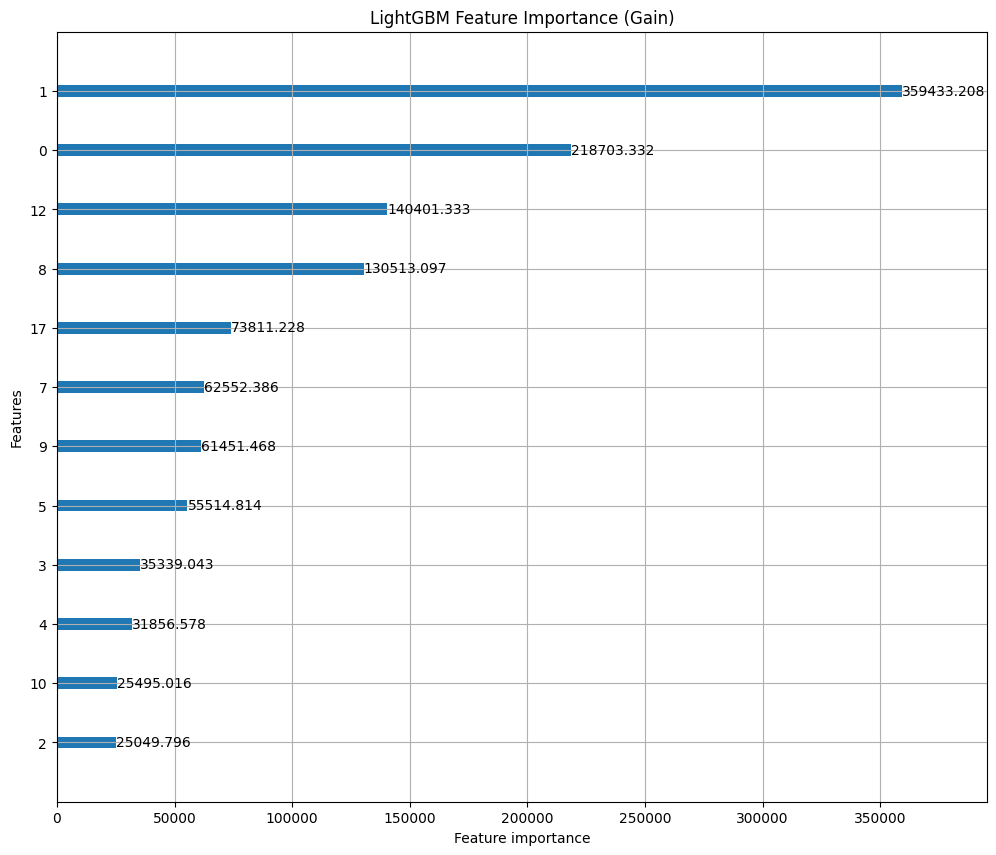

In [68]:
LGB = LGBMClassifier(metric='F1')
LGB.fit(X_train, y_train, categorical_feature=cat_features, eval_metric='F1')
lgb.plot_importance(LGB, importance_type="gain", figsize=(12,10), max_num_features=12,
                    title="LightGBM Feature Importance (Gain)")
plt.show()

In [69]:
importance_values = LGB.booster_.feature_importance(importance_type='gain')

feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance_values
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

best_features_1 = feature_importance_df.head(15)['Feature']

## Tuned LightGBM

In [70]:
perm_importance = permutation_importance(LGB, X_train, y_train, n_repeats=10, random_state=42)

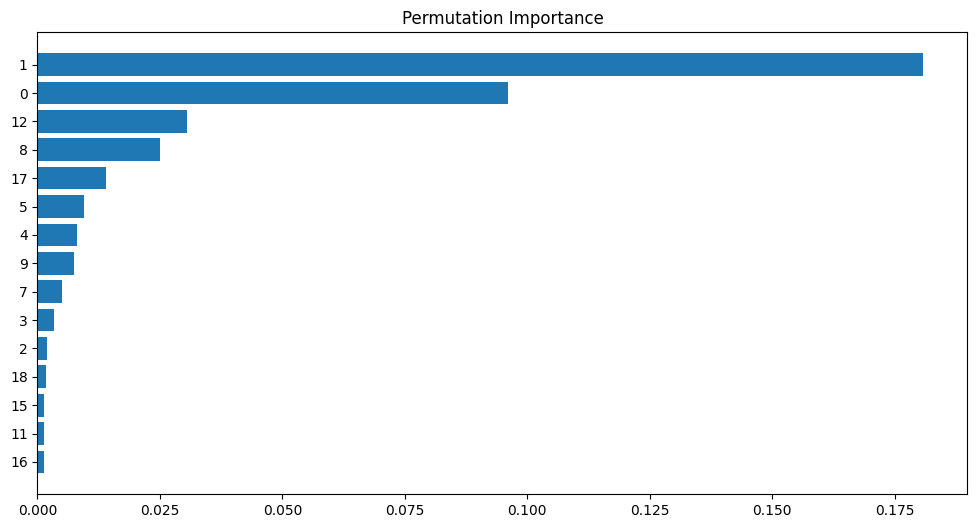

In [71]:
sorted_idx = perm_importance.importances_mean.argsort()[-n_features:]
best_features_2 = X_train.columns[sorted_idx][-n_features:].values

fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.title('Permutation Importance');

In [72]:
best_features = [i for i in best_features_1 if i in best_features_2]

In [73]:
logging.basicConfig(level=logging.INFO)

def objective(trial: Trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_depth': trial.suggest_int('max_depth', -1, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 100, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 100, log=True),
        'verbosity': -1
    }

    lightgbm_model = LGBMClassifier(**params)
    lightgbm_model.fit(X_train[best_features], y_train)
    prediction = lightgbm_model.predict(X_test[best_features])
    
    score = f1_score(y_test, prediction)
    logging.info(f"Trial {trial.number}: params={params}, score={score}")
    
    return score

In [74]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

df = study.trials_dataframe()

[I 2024-09-07 11:35:02,817] A new study created in memory with name: no-name-78379062-c0a8-422d-b0c7-2502db402d02


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-09-07 11:37:09,251] Trial 0 finished with value: 0.9473644411201435 and parameters: {'n_estimators': 954, 'max_depth': 11, 'learning_rate': 0.0005714749625885501, 'num_leaves': 32, 'feature_fraction': 0.8268962923895, 'bagging_fraction': 0.7100080379792898, 'bagging_freq': 5, 'min_child_samples': 87, 'reg_alpha': 0.005236962276650092, 'reg_lambda': 2.903516483974994}. Best is trial 0 with value: 0.9473644411201435.
[I 2024-09-07 11:37:58,083] Trial 1 finished with value: 0.933652105789232 and parameters: {'n_estimators': 834, 'max_depth': 2, 'learning_rate': 0.016003209156457233, 'num_leaves': 52, 'feature_fraction': 0.7494109192722049, 'bagging_fraction': 0.7453227364387561, 'bagging_freq': 1, 'min_child_samples': 66, 'reg_alpha': 0.004460444540423867, 'reg_lambda': 7.097462723025672}. Best is trial 0 with value: 0.9473644411201435.
[I 2024-09-07 11:38:13,658] Trial 2 finished with value: 0.9358292571467257 and parameters: {'n_estimators': 293, 'max_depth': 2, 'learning_rate':

In [75]:
study.best_params

{'n_estimators': 759,
 'max_depth': 8,
 'learning_rate': 0.0005576844575335995,
 'num_leaves': 68,
 'feature_fraction': 0.5855646998632151,
 'bagging_fraction': 0.8380030463661645,
 'bagging_freq': 7,
 'min_child_samples': 49,
 'reg_alpha': 7.2643781537417675,
 'reg_lambda': 0.15485952090255517}

In [76]:
best_params = {'n_estimators': 759,
 'max_depth': 8,
 'learning_rate': 0.0005576844575335995,
 'num_leaves': 68,
 'feature_fraction': 0.5855646998632151,
 'bagging_fraction': 0.8380030463661645,
 'bagging_freq': 7,
 'min_child_samples': 49,
 'reg_alpha': 7.2643781537417675,
 'reg_lambda': 0.15485952090255517}

lightgbm_model = LGBMClassifier(**best_params)
lightgbm_model.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.8712187238496423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8712187238496423
[LightGBM] [Warning] bagging_fraction is set=0.8737360320599473, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8737360320599473
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8712187238496423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8712187238496423
[LightGBM] [Warning] bagging_fraction is set=0.8737360320599473, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8737360320599473
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 248591, number of negative: 149155
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.218426 seconds.
You c

LGBMClassifier(bagging_fraction=0.8737360320599473, bagging_freq=1,
               feature_fraction=0.8712187238496423,
               learning_rate=0.0004356282039193776, max_depth=11,
               min_child_samples=46, n_estimators=881, num_leaves=143,
               reg_alpha=0.19787532331002414, reg_lambda=4.625210195673949)

In [77]:
lgbm_prediction = lightgbm_model.predict_proba(X_test)

[LightGBM] [Warning] feature_fraction is set=0.8712187238496423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8712187238496423
[LightGBM] [Warning] bagging_fraction is set=0.8737360320599473, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8737360320599473
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


In [78]:
lgbm_prediction = lgbm_prediction[:, 1]
lgbm_prediction

array([0.72224663, 0.64113125, 0.69250189, ..., 0.47653387, 0.71461668,
       0.69047573])

In [79]:
best_params = {'n_estimators': 759,
 'max_depth': 8,
 'learning_rate': 0.0005576844575335995,
 'num_leaves': 68,
 'feature_fraction': 0.5855646998632151,
 'bagging_fraction': 0.8380030463661645,
 'bagging_freq': 7,
 'min_child_samples': 49,
 'reg_alpha': 7.2643781537417675,
 'reg_lambda': 0.15485952090255517}

final_lightgbm_model = LGBMClassifier(**best_params)
final_lightgbm_model.fit(X, y)

[LightGBM] [Warning] feature_fraction is set=0.8712187238496423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8712187238496423
[LightGBM] [Warning] bagging_fraction is set=0.8737360320599473, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8737360320599473
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8712187238496423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8712187238496423
[LightGBM] [Warning] bagging_fraction is set=0.8737360320599473, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8737360320599473
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 552217, number of negative: 186695
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.776050 seconds.
You c

LGBMClassifier(bagging_fraction=0.8737360320599473, bagging_freq=1,
               feature_fraction=0.8712187238496423,
               learning_rate=0.0004356282039193776, max_depth=11,
               min_child_samples=46, n_estimators=881, num_leaves=143,
               reg_alpha=0.19787532331002414, reg_lambda=4.625210195673949)

In [80]:
final_lightgbm_prediction = final_lightgbm_model.predict_proba(solution)

[LightGBM] [Warning] feature_fraction is set=0.8712187238496423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8712187238496423
[LightGBM] [Warning] bagging_fraction is set=0.8737360320599473, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8737360320599473
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


In [81]:
final_lightgbm_prediction = final_lightgbm_prediction[:, 1]
final_lightgbm_prediction

array([0.80985668, 0.72191155, 0.75763305, 0.82299129, 0.57107764,
       0.54969606, 0.82335943, 0.79932164, 0.82349383, 0.66594768,
       0.8030652 , 0.70412933, 0.54232684, 0.81192835, 0.56155802,
       0.81522532, 0.62044745, 0.79232263, 0.81660915, 0.8181664 ,
       0.75876125, 0.82349913, 0.785419  , 0.67156326, 0.78403007,
       0.80509776, 0.54799693, 0.81659553, 0.72558111, 0.55424656,
       0.82349913, 0.81553562, 0.80272761, 0.82338198, 0.80733042,
       0.7495281 , 0.82349913, 0.81330366, 0.81548656, 0.79354788,
       0.67751359, 0.77811503, 0.82345061, 0.73508108, 0.77748267,
       0.80920145, 0.6361464 , 0.8198979 , 0.77214455, 0.68376817,
       0.75017757, 0.80313279, 0.80776383, 0.78025071, 0.82345546,
       0.64367601, 0.82336554, 0.81572424, 0.75403794, 0.82342329,
       0.82323249, 0.80389116, 0.81683666, 0.81800062, 0.73469835,
       0.82349913, 0.8232852 , 0.81112664, 0.81660109, 0.80909829,
       0.81482079, 0.82299129, 0.82348777, 0.76432136, 0.62308

In [83]:
submission = pd.DataFrame({'ID':solution.index})
submission['result'] = final_lightgbm_model.predict(solution)

[LightGBM] [Warning] feature_fraction is set=0.8712187238496423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8712187238496423
[LightGBM] [Warning] bagging_fraction is set=0.8737360320599473, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8737360320599473
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


In [84]:
submission['result'].value_counts()

result
1    342
Name: count, dtype: int64

In [ ]:
submission.to_csv('Tuned_LightGBM.csv', index=False)

# Ensembles

## Ensemble with LogisticRegression

In [85]:
train_meta = pd.DataFrame({
    'cat': cat_prediction,
    'xgb': xgb_prediction,
    'lgbm': lgbm_prediction
})

In [86]:
test_meta = pd.DataFrame({
    'cat': final_cat_prediction, 
    'xgb': final_xgb_prediction,
    'lgbm': final_lightgbm_prediction
})

In [87]:
metamodel = LogisticRegression(fit_intercept=False)
metamodel.fit(train_meta, test['result'])

LogisticRegression(fit_intercept=False)

In [88]:
meta_predictions = metamodel.predict(test_meta)
meta_probabilities = metamodel.predict_proba(test_meta)[:, 1]

In [89]:
len(meta_predictions) - meta_predictions.sum()

32

## Ensemple with Boosting

In [90]:
boosting_metamodel = GradientBoostingClassifier()
boosting_metamodel.fit(train_meta, test['result'])

GradientBoostingClassifier()

In [91]:
boost_meta_predictions = boosting_metamodel.predict(test_meta)
boost_meta_probabilities = boosting_metamodel.predict_proba(test_meta)[:, 1]

In [92]:
for i in range(len(boost_meta_predictions)):
    if (boost_meta_predictions == 0)[i] == True:
        print(i)

12
14
89
116


**Authors:**
* Andrew Nizow ([github](https://github.com/AndrewsCollider) and [kaggle](https://www.kaggle.com/andrewnizov))
* Nikita Chuikin ([github](https://github.com/AnalyseOptimize) and [kaggle](https://www.kaggle.com/chuikinnikita))